In [1]:
# %matplotlib inline 


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, preps, strats, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(preps)
importlib.reload(strats)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime, time, timedelta

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)


Selected checkpoint: trainings/AAPL_0.33972_fin.pth

Hyperparameters:
{'ALPHA_SMOOTH': 0,
 'CLIPNORM': 2,
 'CONV_CHANNELS': 64,
 'CONV_DILATION': 1,
 'CONV_K': 3,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'DROPOUT_TRANS': 0.03,
 'EARLY_STOP_PATIENCE': 9,
 'FLATTEN_MODE': 'attn',
 'HEAD_LR_PCT': 1,
 'HUBER_DELTA': 0.1,
 'LAMBDA_DELTA': 0.1,
 'LONG_UNITS': 64,
 'LOOK_BACK': 60,
 'MAX_EPOCHS': 90,
 'MICRO_SAMPLE_K': 16,
 'ONECYCLE_DIV_FACTOR': 10,
 'ONECYCLE_FINAL_DIV': 100,
 'ONECYCLE_MAX_LR': 0.0002,
 'ONECYCLE_PCT_START': 0.1,
 'ONECYCLE_STRATEGY': 'cos',
 'PRED_HIDDEN': 96,
 'SHORT_UNITS': 64,
 'TCN_CHANNELS': 64,
 'TCN_KERNEL': 3,
 'TCN_LAYERS': 1,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 4,
 'TRAIN_WORKERS': 8,
 'TRANSFORMER_D_MODEL': 64,
 'TRANSFORMER_FF_MULT': 4,
 'TRANSFORMER_HEADS': 4,
 'TRANSFORMER_LAYERS': 2,
 'USE_CONV': False,
 'USE_DELTA': False,
 'USE_HUBER': False,
 'USE_LONG_LSTM': False,
 'USE_SHORT_LSTM': False,
 'USE_TCN': False,
 'USE_TRANSFORMER': True,
 'V

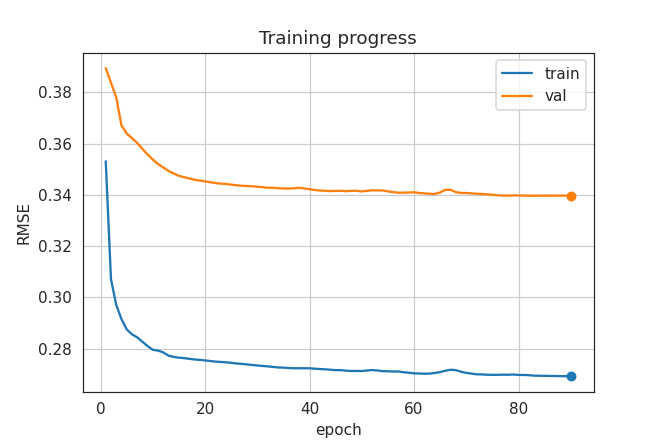


Train metrics: {'rmse': 0.2693190955911251, 'mae': 0.15552100837897043, 'r2': 0.21803372739402715}
 Val metrics: {'rmse': 0.339746478627548, 'mae': 0.16473371837166356, 'r2': 0.23809439275075728}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (input_proj): Linear(in_features=50, out_features=50, bias=True)
  (feature_proj): Linear(in_features=50, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
     

In [3]:
fname = f"{params.ticker}_{params.sel_val_rmse}_fin.pth"
model_path = Path(params.models_folder) / fname

print("Selected checkpoint:", model_path)

# Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

model_feats = ckpt['features']
print("\nFeatures:")
print(model_feats)

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# Reinstantiate a *clean* model in CPU memory
model_choice = models_custom.ModelClass(
    n_feats             = len(model_feats),
    short_units         = ckpt["hparams"]["SHORT_UNITS"],
    long_units          = ckpt["hparams"]["LONG_UNITS"],
    transformer_d_model = ckpt["hparams"]["TRANSFORMER_D_MODEL"],
    transformer_layers  = ckpt["hparams"]["TRANSFORMER_LAYERS"],
    dropout_short       = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long        = ckpt["hparams"]["DROPOUT_LONG"],
    dropout_trans       = ckpt["hparams"]["DROPOUT_TRANS"],
    pred_hidden         = ckpt["hparams"]["PRED_HIDDEN"],
    look_back           = ckpt["hparams"]["LOOK_BACK"],

    # Gating flags
    use_conv            = ckpt["hparams"]["USE_CONV"],
    use_tcn             = ckpt["hparams"]["USE_TCN"],
    use_short_lstm      = ckpt["hparams"]["USE_SHORT_LSTM"],
    use_transformer     = ckpt["hparams"]["USE_TRANSFORMER"],
    use_long_lstm       = ckpt["hparams"]["USE_LONG_LSTM"],
    use_delta           = ckpt["hparams"]["USE_DELTA"],
    flatten_mode        = ckpt["hparams"]["FLATTEN_MODE"]
)

# Load *only* the weight tensors into that fresh model
model_choice.load_state_dict(ckpt["model_state_dict"])
model_choice.to(params.device)
model_choice.eval()

model_choice


In [4]:
cols = params.features_cols_tick + params.signals_cols_tick + [f"{col}_raw" for col in params.strategy_cols_tick]
cols = list(dict.fromkeys(cols))   # remove duplicates, keep order
df_sign_selfeats = pd.read_csv(params.sign_featall_csv, index_col=0, parse_dates=True)[cols]

df_sign_selfeats = df_sign_selfeats[df_sign_selfeats.index.year >= params.init_df_year] ###########
df_sign_selfeats

,range_pct,atr_pct_7,atr_pct_28,time_afthour,time_premark,kc_w_20_20_2.0,bb_w_20_2p0,donch_w_20,ret_std_63,atr_pct_14,donch_w_55,ret_std_21,upper_shad,time_in_sess,dist_high_200,bb_w_50_2p0,lower_shad,time_hour,dist_low_200,time_week_of_year,trade_count,volume,atr_7_RZ,atr_14_RZ,atr_28_RZ,time_day_of_year,time_month,vol_spike_28,plus_di_28,stoch_k_14_3_3,rolling_max_close_200_RZ,adx_14,minus_di_28,minus_di_14,cci_20,plus_di_7,plus_di_14,adx_28,rsi_6,rolling_min_close_200_RZ,vol_spike_14,stoch_d_9_3_3,sma_5_RZ,minus_di_7,sma_21_RZ,sma_9_RZ,cci_14,sma_pct_200,stoch_k_9_3_3,cmf_14,close_raw,signal_raw,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw
2021-01-04 08:00:00,1.000000,0.338978,0.127922,0.0,1.0,0.160796,0.321196,0.363267,0.353677,0.204937,0.212466,0.606572,0.0000,0.0,0.000000,0.120169,1.000000,0.270833,0.221604,0.500000,0.021928,0.023813,1.000000,1.000000,1.000000,0.508219,0.5,1.000000,1.000000,0.476190,0.602943,0.110955,0.055087,0.048084,1.000000,0.906456,0.946395,0.099845,0.957149,0.366904,1.000000,0.307407,0.595008,0.027953,0.518204,0.536184,1.000000,0.733673,0.533333,0.593829,133.490,0.490203,0.122127,0.075538,18.067861,95.653507,133.490000
2021-01-04 08:01:00,0.000000,0.290199,0.123036,0.0,1.0,0.152341,0.440811,0.363267,0.353723,0.189952,0.212466,0.606867,0.0000,0.0,0.000000,0.170896,0.000000,0.270833,0.221604,0.500000,0.006374,0.000883,1.000000,1.000000,1.000000,0.508219,0.5,0.070334,1.000000,0.714286,0.602943,0.173380,0.055087,0.048084,1.000000,0.906456,0.946395,0.139610,0.957149,0.366904,0.052302,0.488889,0.731926,0.027953,0.543925,0.612670,1.000000,0.732627,0.733333,0.644794,133.490,0.555467,0.122127,0.070143,23.015363,95.653507,133.490000
2021-01-04 08:02:00,0.217279,0.289559,0.129858,0.0,1.0,0.160104,0.528420,0.414585,0.353572,0.197844,0.243987,0.607060,0.0000,0.0,0.022949,0.209768,0.000000,0.270833,0.223945,0.500000,0.007394,0.000862,1.000000,1.000000,1.000000,0.508219,0.5,0.068340,1.000000,0.962963,0.602943,0.232773,0.042741,0.040644,0.985879,0.924088,0.974171,0.179371,0.957877,0.366904,0.051305,0.743210,0.872683,0.023899,0.569240,0.690392,0.862231,0.734115,0.962963,0.625258,133.500,0.616576,0.122127,0.072990,27.722587,95.726024,133.490418
2021-01-04 08:03:00,0.000000,0.251565,0.125942,0.0,1.0,0.153131,0.597300,0.414553,0.353524,0.185335,0.243968,0.606768,0.0000,0.0,0.020653,0.242206,0.000000,0.270833,0.226286,0.500000,0.004335,0.000433,0.893816,0.997150,1.000000,0.508219,0.5,0.041172,1.000000,0.929630,0.602943,0.287924,0.041682,0.040001,0.845164,0.910440,0.963708,0.217713,0.958718,0.366904,0.031126,0.875309,1.000000,0.023535,0.592634,0.767120,0.757567,0.735576,0.929630,0.627741,133.510,0.684110,0.122127,0.068491,32.093580,95.809913,133.490904
2021-01-04 08:04:00,0.151845,0.312128,0.148163,0.0,1.0,0.182330,0.691480,0.493115,0.363829,0.222961,0.292223,0.619547,0.0000,0.0,0.011456,0.286908,0.153846,0.270833,0.275352,0.500000,0.007394,0.001541,1.000000,1.000000,1.000000,0.508219,0.5,0.108676,1.000000,0.914053,0.602944,0.341685,0.018270,0.026207,0.847899,0.947830,1.000000,0.257234,0.972625,0.366904,0.086632,0.935549,1.000000,0.016019,0.623524,0.866333,0.767997,0.788750,0.914053,0.641943,133.720,0.428829,0.122127,0.082170,36.354425,97.196553,133.505081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29:00,0.134332,0.190067,0.202690,0.0,0.0,0.195248,0.203577,0.213304,0.172218,0.190330,0.121831,0.173700,0.2400,1.0,0.004729,0.114646,0.207692,0.645833,0.285845,0.519231,0.281999,0.054167,0.145232,0.140438,0.150573,0.521918,0.5,0.247562,0.360762,0.958040,0.602940,0.161600,0.171854,0.109079,0.985913,0.495497,0.407921,0.113547,0.882500,1.000000,0.318022,0.907809,0.488809,0.032127,0.439971,0.470742,0.992630,0.641047,0.932446,0.711288,259.120,0.000000,0.114549,0.136420,22.081776,88.210255,258.042621
2026

In [5]:
# importlib.reload(params)
# importlib.reload(models_core)

train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_sign_selfeats,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    look_back       = params.hparams["LOOK_BACK"],
    features_cols   = params.features_cols_tick,
)

Preparing days:   0%|          | 0/1261 [00:00<?, ?it/s]

N_total: 1119269 look_back: 60 F: 50
Estimated X_buf size: 13.43 GB — using RAM (in-memory) (thresh 56 GiB)


Writing days:   0%|          | 0/1261 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [6]:
# for name, ld, tm in zip(
#     ["train","val","test"],
#     [train_loader, val_loader, test_loader],
#     [end_times_tr, end_times_val, end_times_te]
# ):
#     models_core.summarize_split(name, ld, tm)

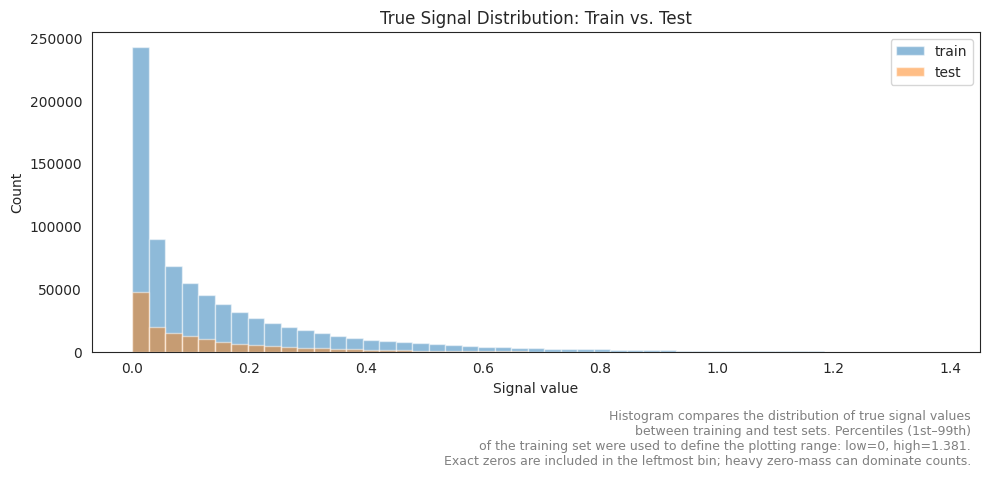

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_test = np.concatenate([batch[1].cpu().numpy().ravel() for batch in test_loader])

low, high = np.percentile(y_train, [1, 99])
bins = np.linspace(low, high, 50)   # zeros will be included in the leftmost bin if <= low

plt.figure(figsize=(10,5))
plt.hist(y_train, bins=bins, alpha=0.5, label="train")
plt.hist(y_test,   bins=bins, alpha=0.5, label="test")

# description / annotation
desc = (
    "Histogram compares the distribution of true signal values\n"
    "between training and test sets. Percentiles (1st–99th)\n"
    f"of the training set were used to define the plotting range: low={low:.4g}, high={high:.4g}.\n"
    "Exact zeros are included in the leftmost bin; heavy zero-mass can dominate counts."
)
plt.title("True Signal Distribution: Train vs. Test")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.legend()
plt.gca().text(
    0.99, -0.18, desc, ha="right", va="top", transform=plt.gca().transAxes,
    fontsize=9, color="gray"
)
plt.tight_layout()
plt.show()



In [8]:
# importlib.reload(models_custom) ########

print('Calculating Train metrics and predictions...')
train_metrics, _, train_preds, _, _ = \
    models_custom.eval_on_loader(train_loader, model_choice)

print('Calculating Val metrics and predictions...')
val_metrics, _, val_preds, _, _  = \
    models_custom.eval_on_loader(val_loader,   model_choice)

print('Calculating Test metrics and predictions...')
test_metrics, _, test_preds, _, _ = \
    models_custom.eval_on_loader(test_loader,  model_choice)


# Simple summary
print("=== SIMPLE SUMMARY ===\n")

print("Predictions lengths:")
print(f"  Train : {len(train_preds)}")
print(f"  Valid : {len(val_preds)}")
print(f"  Test  : {len(test_preds)}\n")

print("Metrics:")
print(f"  Train → RMSE={train_metrics['rmse']:.5f}, MAE={train_metrics['mae']:.5f}, R²={train_metrics['r2']:.5f}")
print(f"  Valid → RMSE={val_metrics['rmse']:.5f}, MAE={val_metrics['mae']:.5f}, R²={val_metrics['r2']:.5f}")
print(f"  Test  → RMSE={test_metrics['rmse']:.5f}, MAE={test_metrics['mae']:.5f}, R²={test_metrics['r2']:.5f}\n")

print("Predictions stats (mean±std):")
print(f"  Train : {train_preds.mean():.5f} ± {train_preds.std():.5f}")
print(f"  Valid : {val_preds.mean():.5f} ± {val_preds.std():.5f}")
print(f"  Test  : {test_preds.mean():.5f} ± {test_preds.std():.5f}")


Calculating Train metrics and predictions...


eval:   0%|          | 0/56 [00:00<?, ?it/s]

Calculating Val metrics and predictions...


eval:   0%|          | 0/176 [00:00<?, ?it/s]

Calculating Test metrics and predictions...


eval:   0%|          | 0/189 [00:00<?, ?it/s]

=== SIMPLE SUMMARY ===

Predictions lengths:
  Train : 791826
  Valid : 158150
  Test  : 169293

Metrics:
  Train → RMSE=0.26854, MAE=0.15593, R²=0.22266
  Valid → RMSE=0.34033, MAE=0.16590, R²=0.23825
  Test  → RMSE=0.27867, MAE=0.15505, R²=0.19296

Predictions stats (mean±std):
  Train : 0.19174 ± 0.14315
  Valid : 0.19768 ± 0.18857
  Test  : 0.18677 ± 0.15097


In [9]:
# importlib.reload(models_custom)

# Stamp predictions, then split into train+val & test
df_trainval, df_test = models_custom.add_preds_and_split( 
    df            = df_sign_selfeats,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

df_test

Stamping train:   0%|          | 0/791826 [00:00<?, ?ts/s]

Stamping val:   0%|          | 0/158150 [00:00<?, ?ts/s]

Stamping test:   0%|          | 0/169293 [00:00<?, ?ts/s]

,range_pct,atr_pct_7,atr_pct_28,time_afthour,time_premark,kc_w_20_20_2.0,bb_w_20_2p0,donch_w_20,ret_std_63,atr_pct_14,donch_w_55,ret_std_21,upper_shad,time_in_sess,dist_high_200,bb_w_50_2p0,lower_shad,time_hour,dist_low_200,time_week_of_year,trade_count,volume,atr_7_RZ,atr_14_RZ,atr_28_RZ,time_day_of_year,time_month,vol_spike_28,plus_di_28,stoch_k_14_3_3,rolling_max_close_200_RZ,adx_14,minus_di_28,minus_di_14,cci_20,plus_di_7,plus_di_14,adx_28,rsi_6,rolling_min_close_200_RZ,vol_spike_14,stoch_d_9_3_3,sma_5_RZ,minus_di_7,sma_21_RZ,sma_9_RZ,cci_14,sma_pct_200,stoch_k_9_3_3,cmf_14,close_raw,signal_raw,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,pred_signal,ask,bid
2025-04-10 08:59:00,0.136139,0.477069,0.599540,0.0,1.0,0.579946,0.710388,0.618412,1.000000,0.551991,0.706512,0.497327,0.0000,0.0,0.996929,0.784181,0.000000,0.270833,0.039387,0.769231,0.022183,0.002051,0.121348,0.148134,0.173542,0.771233,0.75,0.075819,0.129993,0.106227,0.00000,0.483356,0.628877,0.527484,0.286294,0.083355,0.116486,0.572363,0.298715,0.366903,0.105526,0.074668,0.419177,0.445239,0.428828,0.419794,0.329502,0.000000,0.125107,0.339011,191.760,0.572691,0.340567,0.288023,47.582507,30.001039,193.498075,0.321329,191.798352,191.721648
2025-04-10 09:00:00,0.498580,0.493993,0.601189,0.0,1.0,0.583446,0.712061,0.617664,1.000000,0.557114,0.659795,0.508541,0.0000,0.0,0.959033,0.789635,0.461538,0.312500,0.077040,0.769231,0.029577,0.004000,0.127309,0.147577,0.173031,0.771233,0.75,0.139648,0.165030,0.168498,0.00000,0.477029,0.600371,0.483056,0.346315,0.193249,0.174328,0.573863,0.464563,0.366903,0.212767,0.154311,0.421231,0.368045,0.428520,0.420631,0.384531,0.000000,0.265351,0.286160,191.990,0.327772,0.340567,0.291021,47.081118,46.537765,193.476126,0.317270,192.028398,191.951602
2025-04-10 09:01:00,0.377692,0.488137,0.597612,0.0,1.0,0.578831,0.708696,0.617632,1.000000,0.551427,0.657767,0.508821,1.0000,0.0,0.957387,0.796822,0.307692,0.312500,0.078675,0.769231,0.018358,0.002323,0.125162,0.143411,0.170608,0.771233,0.75,0.091030,0.193710,0.227598,0.00000,0.460642,0.579506,0.451811,0.398250,0.271553,0.219828,0.571882,0.471092,0.366903,0.133603,0.267509,0.423558,0.319111,0.428290,0.423881,0.445530,0.000000,0.412069,0.313578,192.000,0.366105,0.340567,0.288091,45.782309,47.188700,193.463264,0.324358,192.038400,191.961600
2025-04-10 09:02:00,0.697460,0.612927,0.632252,0.0,1.0,0.623258,0.739077,0.671996,1.000000,0.615987,0.700204,0.613566,0.4800,0.0,1.000000,0.820685,0.384615,0.312500,0.008225,0.769231,0.060428,0.008895,0.165332,0.167156,0.190136,0.771233,0.75,0.313874,0.169011,0.192413,0.00000,0.460781,0.652926,0.566871,0.264690,0.185643,0.178758,0.574828,0.233503,0.366903,0.442533,0.350716,0.425108,0.517921,0.427962,0.424829,0.265608,0.000000,0.374728,0.259770,191.310,0.931909,0.340567,0.320370,45.793316,23.498695,193.398325,0.336239,191.348262,191.271738
2025-04-10 09:03:00,0.000000,0.584405,0.625435,0.0,1.0,0.614792,0.746192,0.671182,0.685786,0.602747,0.699346,0.615281,0.0000,0.0,1.000000,0.828795,0.000000,0.312500,0.046004,0.769231,0.016828,0.001028,0.156481,0.162406,0.186122,0.771233,0.75,0.046853,0.161916,0.158767,0.00000,0.460910,0.633135,0.536104,0.310931,0.166465,0.167880,0.577668,0.361807,0.366904,0.062159,0.365436,0.428477,0.464867,0.428196,0.426039,0.318833,0.000000,0.309511,0.282974,191.540,0.783466,0.340567,0.313915,45.803536,36.291960,193.390602,0.316585,191.578308,191.501692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29:00,0.134332,0.190067,0.202690,0.0,0.0,0.195248,0.203577,0.213304,0.172218,0.190330,0.121831,0.173700,0.2400,1.0,0.004729,0.114646,0.207692,0.645833,0.285845,0.519231,0.281999,0.054167,0.145232,0.140438,0.150573,0.521918,0.50,0.247562,0.360762,0.958040,0.60294,0.161600,0.171854,0.109079,0.985913,0.495497,0.407921,

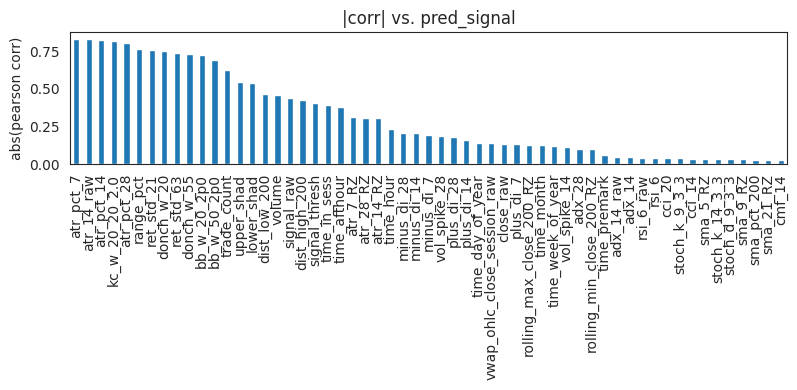

atr_pct_7                      0.835692
atr_14_raw                     0.834789
atr_pct_14                     0.828654
kc_w_20_20_2.0                 0.818901
atr_pct_28                     0.804175
range_pct                      0.768737
ret_std_21                     0.761010
donch_w_20                     0.750768
ret_std_63                     0.738912
donch_w_55                     0.731517
bb_w_20_2p0                    0.725084
bb_w_50_2p0                    0.696367
trade_count                    0.626770
upper_shad                     0.546759
lower_shad                     0.540293
dist_low_200                   0.464117
volume                         0.459520
signal_raw                     0.441713
dist_high_200                  0.426995
signal_thresh                  0.404910
time_in_sess                   0.392071
time_afthour                   0.379292
atr_7_RZ                       0.313167
atr_28_RZ                      0.303879
atr_14_RZ                      0.303797


In [10]:
# Pearson corr between each feature and the pred_signal on the test split

# Identify feature columns (drop non-inputs)
feat_cols = [
    c for c in df_test.columns
    if c not in ("bid","ask", "pred_signal", params.signals_cols_tick)
]

# Compute absolute corr(feature, pred_signal)
corrs = df_test[feat_cols] \
    .corrwith(df_test["pred_signal"]) \
    .abs() \
    .sort_values(ascending=False)

# Bar plot
corrs.plot.bar(figsize=(8,4), title="|corr| vs. pred_signal")
plt.ylabel("abs(pearson corr)")
plt.tight_layout()
plt.show()

corrs

In [11]:
# Descriptive Statistics shows whether the model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

stats = df_test[['targ_signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['targ_signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

,count,mean,std,min,25%,50%,75%,max,range,pearson_r_with_other
signal_raw,169293.0,0.183261,0.310197,0.00000,0.021605,0.087347,0.223088,10.398917,10.398917,0.441713
pred_signal,169293.0,0.186769,0.150971,-0.00707,0.094537,0.153877,0.226217,2.137979,2.145049,0.441713


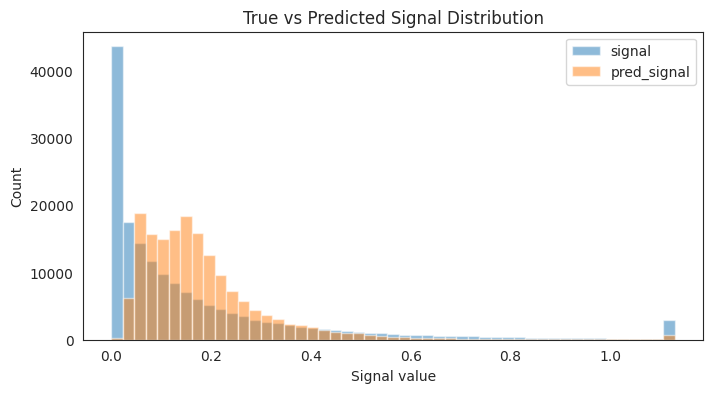

In [12]:
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

a = df_test['targ_signal'].to_numpy(dtype=np.float64)
b = df_test['pred_signal'].to_numpy(dtype=np.float64)
low, high = np.percentile(np.concatenate((a, b)), [1, 99])
bins = np.linspace(low, high, 50)

a_clip = np.clip(a, low, high)
b_clip = np.clip(b, low, high)

plt.figure(figsize=(8,4))
plt.hist(a_clip, bins=bins, alpha=0.5, label='signal')
plt.hist(b_clip, bins=bins, alpha=0.5, label='pred_signal')
plt.title("True vs Predicted Signal Distribution")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.legend()
plt.show()



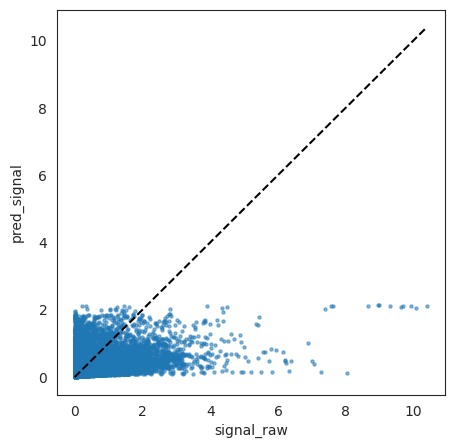

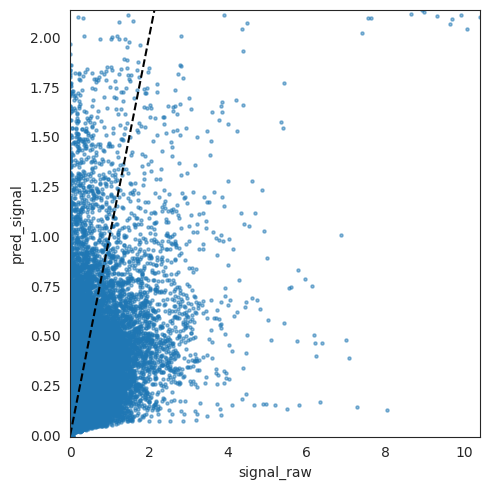

In [13]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

x = df_test['targ_signal'].to_numpy()
y = df_test['pred_signal'].to_numpy()

plt.figure(figsize=(5,5))
plt.scatter(x, y, s=5, alpha=0.5)
mn, mx = min(x.min(), y.min()), max(x.max(), y.max())
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('targ_signal'); plt.ylabel('pred_signal')
plt.show()


plt.figure(figsize=(5,5))
plt.scatter(x, y, s=5, alpha=0.5)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
xl = plt.xlim()            # use visible x-limits for the identity line
plt.plot(xl, xl, 'k--')    # 45° reference without changing axes
plt.xlabel('targ_signal'); plt.ylabel('pred_signal')
plt.tight_layout(); plt.show()



Selected day: 2025-07-01


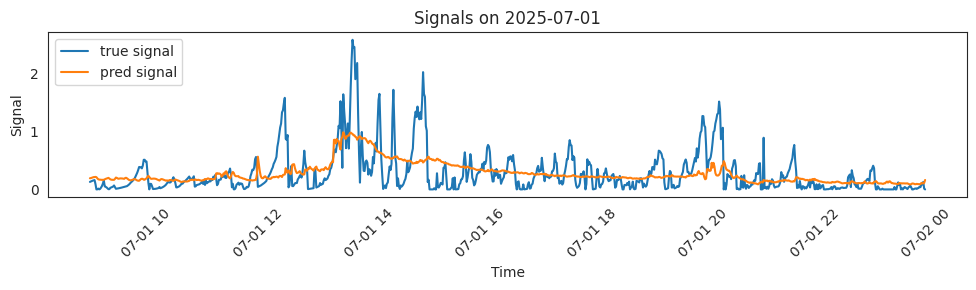

In [14]:
# pick a random day (normalized to midnight)
days = df_test.index.normalize().unique()
random_day = np.random.choice(days)
print("Selected day:", pd.to_datetime(random_day).date())

mask = df_test.index.normalize() == random_day

# Plot true vs. predicted signal on the random day
plt.figure(figsize=(10, 3))
plt.plot(df_test.index[mask], df_test.loc[mask, 'targ_signal'],      label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask, 'pred_signal'], label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

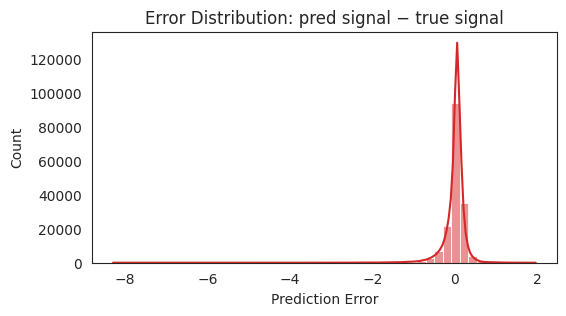

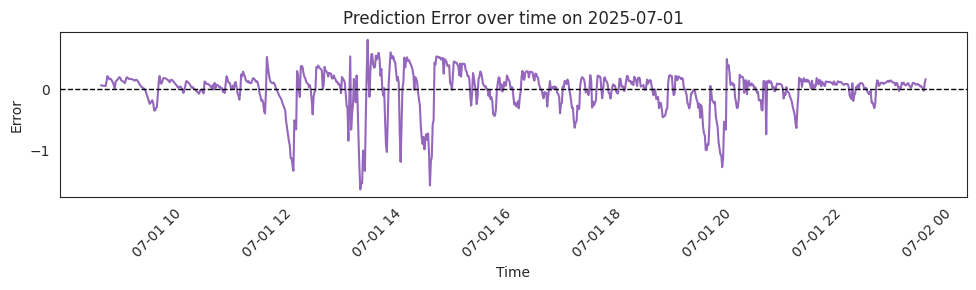

In [15]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding  to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['targ_signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same random day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
# # importlib.reload(params) ######

# col_signal = 'pred_signal'
# sign_thresh = 'signal_thresh' # to be optimized

# df_sim = df_test # select which environment to simulate

# first_day = df_sim.index.normalize().min()
# start_ask = df_sim.loc[df_sim.index.normalize() == first_day, "ask"].iloc[0]
# strats.reset_globals(start_ask)

# sim_results = {}
# groups = df_sim.groupby(df_sim.index.normalize())
# total_days = df_sim.index.normalize().nunique()


# for day, df_day_sim in tqdm(groups, desc="Generate+Simulate", total=total_days):

#     df_actions = strats.generate_actions_alpaca(
#         df              = df_day_sim,
#         col_signal      = col_signal,
#         sign_thresh     = sign_thresh,
#         col_atr         = 'atr_14_raw',
#         col_adx         = 'adx_14_raw',
#         col_rsi         = 'rsi_6_raw',
#         col_vwap        = 'vwap_ohlc_close_session_raw',
#         col_close       = 'close_raw',
#         reset_peak      = params.reset_peak_tick,
#         rsi_min_thresh  = params.rsi_min_thresh_tick,
#         rsi_max_thresh  = params.rsi_max_thresh_tick,
#         atr_mult        = params.atr_mult_tick,
#         vwap_atr_mult   = params.vwap_atr_mult_tick,
#         adx_thresh      = params.adx_thresh_tick,
#         trailstop_pct   = params.trailstop_pct_tick,
#         sess_start      = params.sess_premark,
#     )
    
#     sim_results.update(
#         strats.simulate_trading(
#             day         = day,
#             df          = df_actions,
#             buy_factor  = params.buy_factor_tick,
#             sell_factor = params.sell_factor_tick,
#         )
#     )

# print("Loop finished. Days simulated:", len(sim_results))


Generate+Simulate:   0%|          | 0/189 [00:00<?, ?it/s]

Loop finished. Days simulated: 189


In [21]:
# # importlib.reload(params) ######
# # importlib.reload(strats) ######
# # importlib.reload(plots) ######

# year, month = map(int, params.month_to_check.split("-"))
# dates_in_month = [date for date in sim_results if date.year == year and date.month == month]

# if not dates_in_month:
#     print(f"No simulation data for {params.month_to_check}")
# else:
#     for date in sorted(dates_in_month):
#         df_at_date_plot, trades_at_date, stats_at_date = sim_results[date]
#         plots.plot_trades(
#             df                 = df_at_date_plot,
#             col_signal1        = col_signal,
#             sign_thresh        = sign_thresh, 
#             axis_sig_thresh    = 'second',
#             features           = [params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick],
#             autoscale          = False,
#             col_close          = 'close_raw'
#         )
        
#         print(f"\n{' ' * 50}******* Performance for {date.strftime('%Y-%m-%d')} *******\n")
#         for k,v in stats_at_date.items(): # Print stats dict for each date nicely
#             print(f"{k}:\n" + "\n".join("  "+L for L in (v if isinstance(v,list) else str(v).splitlines())))
#         print("\n" + "="*160 + "\n")

# # final visualizations and monthly aggregations
# strats.aggregate_performance(df = df_sim,
#                              sim_results = sim_results)


In [20]:
# 2) Persist CSVs

print("Saving test CSV…")
params.to_csv_with_progress(df_test, params.test_csv)

print("Saving train+val CSV…")
params.to_csv_with_progress(df_trainval, params.trainval_csv)

Saving test CSV…


Saving CSV: 100%|██████████| 169293/169293 [00:40<00:00, 4229.83rows/s, size=167.8MB]


Saving train+val CSV…


Saving CSV: 100%|██████████| 949976/949976 [03:04<00:00, 5136.22rows/s, size=924.3MB]
